In [56]:
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM

from tensorflow.keras.utils import to_categorical

import numpy as np
import nltk
import matplotlib.pyplot as plt

In [59]:
#load and clean data
raw = open("data.txt", "r")

lines = []
for line in raw:
    if str(line) != '\n':
        lines.append(str(line))

#putting the entirety of the input data into one string
text = ""
for line in lines:
    text += line
tokenized = nltk.word_tokenize(text)

#converting the text into numbers to be processed by the embedding layer of the model
words = [] #one of each word in tokenized will be in here
filtering = lambda x : not x in words #for finding if the word should be added to the words array
find = lambda x : words.index(x) if x in words else -1 #convert each word into a number. -1 means that the item isn't in the vocabulary

for word in tokenized:
    if filtering(word):
        words.append(word)

#x data is every single word in the data set, in order
#y data is every single word that comes after the corresponding x value
x = []
y = []
for i in range(len(tokenized)):
    x.append(find(tokenized[i]))
    if i+1 < len(tokenized):
        y.append(find(tokenized[i+1]))
    else:
        y.append(find("."))

x = np.asarray(x)
y = np.asarray(y)
y = to_categorical(y)

print(x.shape)
print(y.shape)

vocab_size = len(words) + 1

(24496,)
(24496, 4198)


In [63]:
#create and compile model
model = Sequential()

model.add(Embedding(vocab_size, 64, input_length=(1))) #embedding: size of vocabulary, dimension of each value
model.add(LSTM(20))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1, 64)             268736    
                                                                 
 lstm_2 (LSTM)               (None, 20)                6800      
                                                                 
 dense_4 (Dense)             (None, 32)                672       
                                                                 
 dense_5 (Dense)             (None, 4198)              138534    
                                                                 
Total params: 414,742
Trainable params: 414,742
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/200
766/766 [==============================] - 4s 6ms/step - loss: 4.4412 - accuracy: 0.1991
Epoch 2/200
766/766 [==============================] - 4s 6ms/step - loss: 4.3800 - accuracy: 0.2038
Epoch 3/200
766/766 [==============================] - 4s 6ms/step - loss: 4.3263 - accuracy: 0.2041
Epoch 4/200
766/766 [==============================] - 5s 6ms/step - loss: 4.2729 - accuracy: 0.2082
Epoch 5/200
766/766 [==============================] - 4s 6ms/step - loss: 4.2234 - accuracy: 0.2106
Epoch 6/200
766/766 [==============================] - 4s 6ms/step - loss: 4.1775 - accuracy: 0.2118
Epoch 7/200
766/766 [==============================] - 4s 6ms/step - loss: 4.1341 - accuracy: 0.2146
Epoch 8/200
766/766 [==============================] - 4s 6ms/step - loss: 4.0930 - accuracy: 0.2172
Epoch 9/200
766/766 [==============================] - 5s 6ms/step - loss: 4.0534 - accuracy: 0.2184
Epoch 10/200
766/766 [==============================] - 4s 5ms/step - loss: 4.0186 - accura

766/766 [==============================] - 4s 6ms/step - loss: 3.3443 - accuracy: 0.2433
Epoch 82/200
766/766 [==============================] - 4s 6ms/step - loss: 3.3406 - accuracy: 0.2447
Epoch 83/200
766/766 [==============================] - 4s 6ms/step - loss: 3.3383 - accuracy: 0.2449
Epoch 84/200
766/766 [==============================] - 4s 6ms/step - loss: 3.3349 - accuracy: 0.2449
Epoch 85/200
766/766 [==============================] - 4s 6ms/step - loss: 3.3350 - accuracy: 0.2445
Epoch 86/200
766/766 [==============================] - 4s 6ms/step - loss: 3.3300 - accuracy: 0.2450
Epoch 87/200
766/766 [==============================] - 4s 6ms/step - loss: 3.3302 - accuracy: 0.2448
Epoch 88/200
766/766 [==============================] - 4s 6ms/step - loss: 3.3290 - accuracy: 0.2433
Epoch 89/200
766/766 [==============================] - 4s 6ms/step - loss: 3.3257 - accuracy: 0.2434
Epoch 90/200
766/766 [==============================] - 4s 6ms/step - loss: 3.3244 - accuracy: 

766/766 [==============================] - 4s 6ms/step - loss: 3.2363 - accuracy: 0.2464
Epoch 161/200
766/766 [==============================] - 4s 6ms/step - loss: 3.2354 - accuracy: 0.2464
Epoch 162/200
766/766 [==============================] - 4s 6ms/step - loss: 3.2360 - accuracy: 0.2477
Epoch 163/200
766/766 [==============================] - 4s 6ms/step - loss: 3.2326 - accuracy: 0.2487
Epoch 164/200
766/766 [==============================] - 4s 6ms/step - loss: 3.2360 - accuracy: 0.2462
Epoch 165/200
766/766 [==============================] - 4s 6ms/step - loss: 3.2344 - accuracy: 0.2458
Epoch 166/200
766/766 [==============================] - 4s 6ms/step - loss: 3.2336 - accuracy: 0.2471
Epoch 167/200
766/766 [==============================] - 5s 6ms/step - loss: 3.2323 - accuracy: 0.2453
Epoch 168/200
766/766 [==============================] - 4s 6ms/step - loss: 3.2311 - accuracy: 0.2452
Epoch 169/200
766/766 [==============================] - 4s 6ms/step - loss: 3.2305 - a

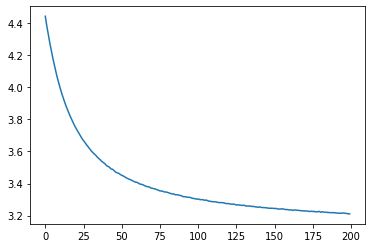

In [65]:
#train model
hist = model.fit(x, y, epochs=200, verbose=1)
plt.plot(hist.history['loss'])
model.save("shakespear2.0.h5")

In [5]:
#test model